[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/cdrc1103/MasterThesis/blob/master/Experiments/MultiClass/GRU.ipynb)

### Setup Notebook

In [1]:
!nvidia-smi

Thu Jun  3 10:20:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
%%capture
%matplotlib inline
!pip install wandb

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Data & Parameters



In [3]:
import json
from pathlib import Path
import pandas as pd

# PARAMETERS FOR EXPERIMENT CONFIGURATION
RUN_ID = "1.3_GRU512RES"
BASE_DIR = Path(f"gdrive/MyDrive/Colab Notebooks/Thesis")
RUN_DIR = BASE_DIR / "MultiClass/Runs"

class Parameter():
  def __init__(self):
    self.__dict__ = {
      "project_name": "thesis_multi-class",
      "train_dataset": "train_RES.csv",
      "test_dataset": "test_RES.csv",
      "embedding_dataset": "wiki-news-300d-1M-subword.vec", # "patent-300.vec", #
      "max_token_length": 30, # number of words/subwords, an instance is truncated to
      "max_tokens": 30000, # vocabulary size
      "embedding_dim": 300, # dimension of the pre-trained embeddings
      "batch_size": 32,
      "learning_rate": 1e-3,
      "epochs": 3,
      "seed": 1, # random seed for reproducability
      "logging": True, # whether to log to the wandb database (True) or to disk (False)
      "n_classes": 17, # how many unique labels there are in the data set
      "in_feature": "abstract", # feature used for training
      "out_feature": "label", # feature to predict
      "sample_weights": False, # whether weights for each training instance should be calculated depending on the label frequency
      "output_size": 256, # output size of the language processing layer, i.e. the CNN, GRU etc. layer
      "dropout_rate": 0.1, # for regularization
    }

# Save to disk          
PARAMS = Parameter()
with open(RUN_DIR / f"{RUN_ID}.json", "w") as f:
  json.dump(PARAMS.__dict__, f)

# Read data sets
train_df = pd.read_csv(BASE_DIR / PARAMS.train_dataset, index_col=0)
train_df = train_df.sample(frac=1, random_state=PARAMS.seed)
test_df = pd.read_csv(BASE_DIR / PARAMS.test_dataset, index_col=0)
test_df = test_df.sample(frac=1, random_state=PARAMS.seed)

# Print stats
print(f"Train data set:{len(train_df)} instances")
print(f"Test data set:{len(test_df)} instances")

Train data set:91849 instances
Test data set:22948 instances


## Configure logging

In [ ]:
# Logging
import wandb

# log to wandb
if PARAMS.logging:
    !wandb login
    run = wandb.init(project=PARAMS.project_name, sync_tensorboard=True)
    run.name = RUN_ID
    log_dir = Path(wandb.run.dir)
    wandb.config.update(PARAMS.__dict__)
# log to disk
else:
    log_dir = RUN_DIR

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: cdrc1103 (use `wandb login --relogin` to force relogin)


## Model

In [4]:
""" Dependencies """
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Bidirectional, GRU, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

""" Apply weights to samples """
if PARAMS.sample_weights:
  # Determine class weights to reduce class imbalance
  class_weight = {}
  total_instances = len(train_df)
  class_freqs = train_df[PARAMS.out_feature].value_counts()
  for class_id, freq in zip(class_freqs.index, class_freqs):
      class_weight[class_id] = total_instances / (freq * PARAMS.n_classes)
  sample_weight = np.zeros(len(train_df))
  for i, class_id in enumerate(train_df[PARAMS.out_feature]):
      sample_weight[i] = class_weight[class_id]

""" Create TF datasets """
# Aggregate features
train_ds = (train_df[PARAMS.in_feature], 
            to_categorical(train_df[PARAMS.out_feature], num_classes=PARAMS.n_classes))
test_ds = (test_df[PARAMS.in_feature], 
          to_categorical(test_df[PARAMS.out_feature], num_classes=PARAMS.n_classes))

# Whether to add weights to data set
if PARAMS.sample_weights:
  train_ds = train_ds + (sample_weight,)

# Transform to tensorflow data set 
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)\
                                              .batch(PARAMS.batch_size)\
                                              .prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(test_ds)\
                                              .batch(PARAMS.batch_size)\
                                              .prefetch(tf.data.AUTOTUNE)

""" Build embeddings """
# Parse file
def get_coefs(word, *arr): 
  return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(BASE_DIR/PARAMS.embedding_dataset))
print("Found %s word vectors in the embedding file." % len(embeddings_index))

# Configure the tokenizer settings
vectorizer = TextVectorization(max_tokens=PARAMS.max_tokens, output_sequence_length=PARAMS.max_token_length)
vectorizer.adapt(train_ds.map(lambda text, label, *args: text))

# Tokenize data set
def tokenize_text(text, label, *args):
  text = tf.expand_dims(text, -1)
  return (vectorizer(text), label, *args)
train_ds = train_ds.map(tokenize_text)
test_ds = test_ds.map(tokenize_text)

# Build lookup table of word/index mappings
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Prepare embedding matrix
num_tokens = len(voc)
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, PARAMS.embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
if PARAMS.logging:
  wandb.log({"unknown words": misses})

""" Build model """
# Configure input feature
int_sequences_input = Input(shape=(None,), dtype="int32")
# Connect input to embedding layer
embedding_layer = Embedding(
  num_tokens,
  PARAMS.embedding_dim,
  embeddings_initializer=Constant(embedding_matrix),
  trainable=False
)
embedded_sequences = embedding_layer(int_sequences_input)
# Bidirectional GRU
x = Bidirectional(GRU(PARAMS.output_size, activation='tanh'))(embedded_sequences)
# Reduce dimensions
x = Dense(PARAMS.output_size, activation="relu")(x)
# Regularize to reduce overfitting
x = Dropout(PARAMS.dropout_rate)(x)
# Reduce to number of classes
preds = Dense(PARAMS.n_classes, activation="softmax")(x)
model = Model(int_sequences_input, preds)

""" Setup otimization """
# Set an optimizer
optimizer = Adam(learning_rate=PARAMS.learning_rate)
# Set loss and metrics
loss = CategoricalCrossentropy()
metrics = [
  Precision(name='precision'), # tp / (tp+fp)
  CategoricalAccuracy(name='accuracy'), # (tp+tn) / (tp+fp+tn+fn)
  Recall(name='recall') # tp / (tp + fn)
]

# Compile the model
model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics)

Found 999995 word vectors in the embedding file.
Converted 19009 words (10991 misses)


NameError: ignored

In [ ]:
from contextlib import redirect_stdout

""" Generate model summary """
print(model.summary())
with open(log_dir/'model_summary.txt', 'w') as file:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: file.write(x + '\n'))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         9000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               857088    
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                4369      
Total params: 9,992,785
Trainable params: 992,785
Non-trainable params: 9,000,000
_____________________________________________

## Training

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
# setup callback for performance logging
tensorboard_callback = TensorBoard(log_dir=log_dir/"logs",
                                   histogram_freq=0,
                                   write_graph=False,
                                   write_images=False,
                                   update_freq=100)

# train the model
history = model.fit(
    x=train_ds,
    epochs=PARAMS.epochs,
    callbacks=[tensorboard_callback],
    verbose=1,
    validation_data=test_ds
    )

Epoch 1/3
2868/2871 [============================>.] - ETA: 0s - loss: 0.9604 - precision: 0.8081 - accuracy: 0.6934 - recall: 0.5923

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


2871/2871 [==============================] - 42s 12ms/step - loss: 0.9601 - precision: 0.8082 - accuracy: 0.6936 - recall: 0.5925 - val_loss: 0.8685 - val_precision: 0.7825 - val_accuracy: 0.7146 - val_recall: 0.6398
Epoch 2/3
2871/2871 [==============================] - 33s 12ms/step - loss: 0.5784 - precision: 0.8581 - accuracy: 0.8083 - recall: 0.7619 - val_loss: 0.8157 - val_precision: 0.7931 - val_accuracy: 0.7402 - val_recall: 0.6889
Epoch 3/3
2871/2871 [==============================] - 33s 12ms/step - loss: 0.4489 - precision: 0.8810 - accuracy: 0.8469 - recall: 0.8148 - val_loss: 0.8405 - val_precision: 0.7907 - val_accuracy: 0.7479 - val_recall: 0.7083


## Evaluate

In [ ]:
# Get predictions on test dataset
predictions = model.predict(
    x=test_ds,
    verbose=1,
    batch_size=PARAMS.batch_size
) # Probability distribution over the labels
np.savetxt(log_dir/"predictions.txt", predictions)

pred_label =np.argmax(predictions, axis=1) # select the prediction with highest probability
true_label = test_df[PARAMS.out_feature].to_numpy() # select the true label from one-hot encoding

718/718 [==============================] - 4s 5ms/step


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"]})
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, brier_score_loss, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import math

In [ ]:
""" Brier score """
def brier(true_label, pred_label, n_classes):
  brier_scores = {}
  for i in range(n_classes):
    row_id = np.where(true_label==i)[0]
    prob = pred_label[row_id, i]
    true = np.ones(len(prob))
    brier_scores[i] = brier_score_loss(true, prob).round(2)
  return brier_scores
brier_scores = brier(true_label, predictions, PARAMS.n_classes)
if PARAMS.logging:
  wandb.log({"brier": brier_scores})
brier_scores

{0: 0.44,
 1: 0.15,
 2: 0.27,
 3: 0.08,
 4: 0.2,
 5: 0.17,
 6: 0.16,
 7: 0.27,
 8: 0.21,
 9: 0.24,
 10: 0.32,
 11: 0.52,
 12: 0.46,
 13: 0.56,
 14: 0.51,
 15: 0.17,
 16: 0.42}

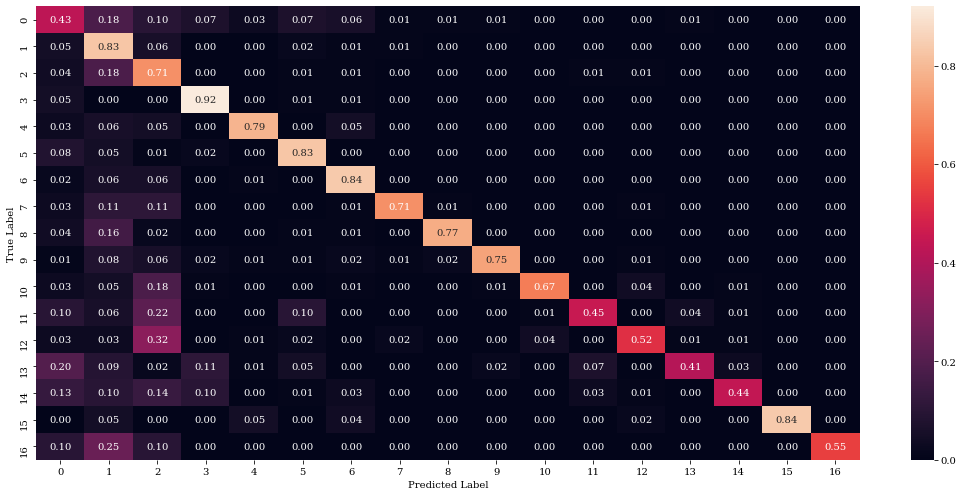

In [ ]:
""" Confusion matrix """
def plot_cm(true_label, pred_label, n_classes):
    # compute values
    cm = confusion_matrix(true_label, pred_label, labels=np.arange(0,n_classes))
    # normalize values
    sum_per_label = np.sum(cm, axis=1)
    cm_norm = cm / sum_per_label[:, None]
    cm_norm =np.round(cm_norm, 2)
    # plot
    fig = plt.figure(figsize=(15,7))
    sns.heatmap(cm_norm, annot=True, fmt=".2f")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.plot()
    return fig

fig = plot_cm(true_label, pred_label, PARAMS.n_classes)
fig.savefig(log_dir/"confusion.png", dpi=150)

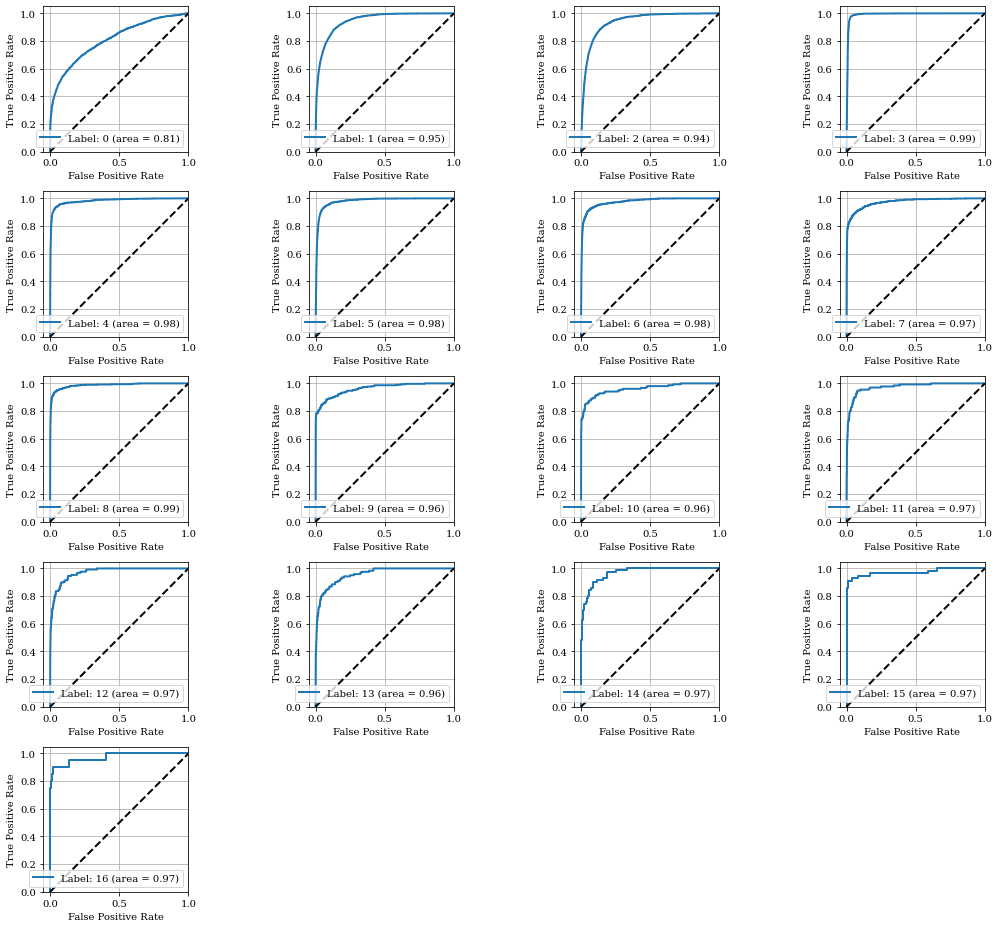

In [ ]:
""" Receiver operating characteristic """
def plot_roc(true_label, pred_label, n_classes):
    fig = plt.figure(figsize=(15, 13))
    linewidth = 2
    fpr = {}
    tpr = {}
    roc_auc = {}
    cols = math.floor(math.sqrt(n_classes))
    rows = math.ceil(n_classes / cols)
    
    # calculate class-wise rocs
    for i in range(n_classes):
        row_id = np.where(true_label==i)[0]
        binary_truth = np.zeros(len(true_label))
        binary_truth[row_id] = 1
        fpr[i], tpr[i], _ = roc_curve(binary_truth, pred_label[:,i], pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.subplot(rows, cols, i+1)
        plt.plot(fpr[i], tpr[i], linewidth=linewidth,
                 label='Label: %i (area = %0.2f)' % (i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='black', lw=linewidth, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([-0.05, 1])
        plt.ylim([0, 1.05])
        plt.grid(True)
        plt.legend(loc='lower right')
        ax = plt.gca()
        ax.set_aspect('equal')
    plt.tight_layout()
    return fig

roc = plot_roc(true_label, predictions, PARAMS.n_classes)
roc.savefig(log_dir/"roc.png", dpi=150)

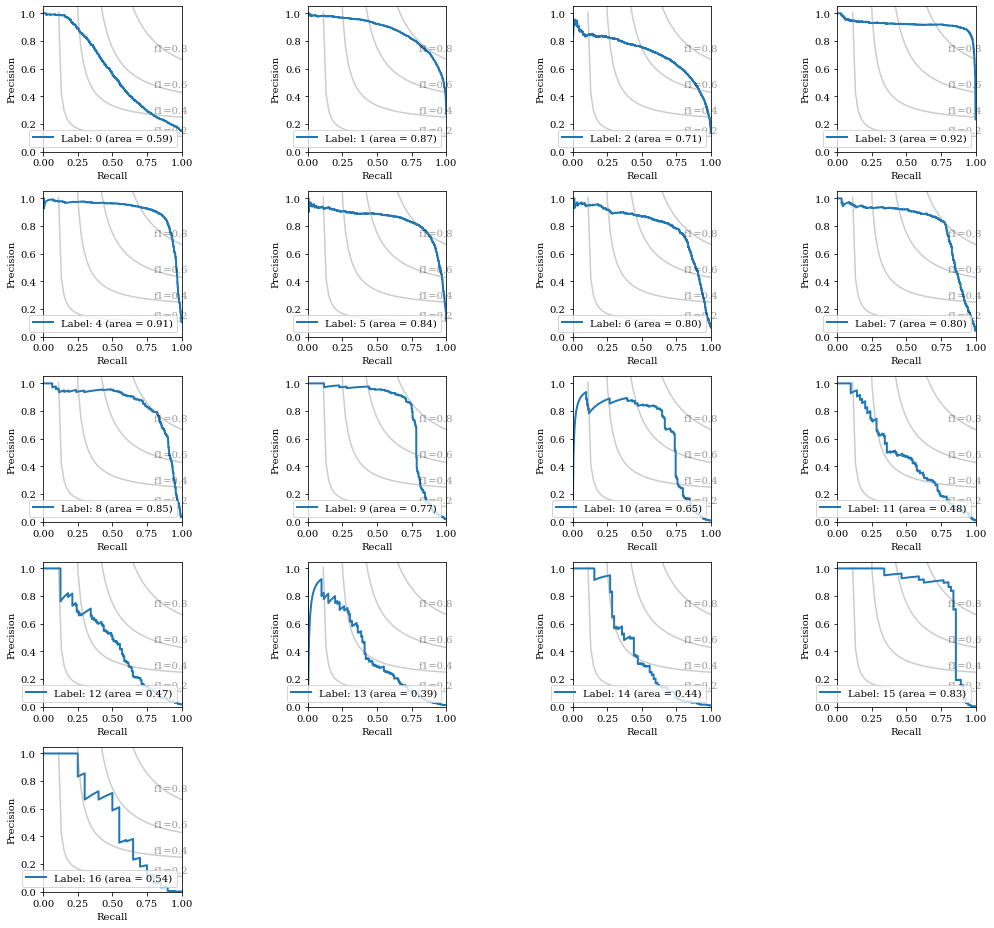

In [ ]:
def plot_prec(true_label, pred_label, n_classes):
  precision = dict()
  recall = dict()
  average_precision = dict()
  fig = plt.figure(figsize=(15, 13))
  linewidth = 2
  cols = math.floor(math.sqrt(n_classes))
  rows = math.ceil(n_classes / cols)

  for i in range(n_classes):
      row_id = np.where(true_label==i)[0]
      binary_truth = np.zeros(len(true_label))
      binary_truth[row_id] = 1
      precision[i], recall[i], _ = precision_recall_curve(binary_truth, pred_label[:,i])
      average_precision[i] = average_precision_score(binary_truth, pred_label[:,i])

      plt.subplot(rows, cols, i+1)
      plt.plot(recall[i], precision[i], lw=linewidth, label="Label: %i (area = %0.2f)" %(i, average_precision[i]))
      plt.legend(loc='lower right')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      f_scores = np.linspace(0.2, 0.8, num=4)
      lines = []
      labels = []
      for f_score in f_scores:
          x = np.linspace(0.01, 1)
          y = f_score * x / (2 * x - f_score)
          l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.4)
          plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.8, y[45] + 0.02), alpha=0.4)
      ax = plt.gca()
      ax.set_aspect('equal')
  plt.tight_layout()

  return fig

prec = plot_prec(true_label, predictions, PARAMS.n_classes)
prec.savefig(log_dir/"prec.png", dpi=150)

In [ ]:
""" Classification report """
def create_report(true_label, pred_label, n_classes):
  cls_names =[str(cls) for cls in np.arange(0, n_classes)]
  cls_report = classification_report(true_label, pred_label, target_names=cls_names, output_dict=True)
  return pd.DataFrame(cls_report).round(2).transpose()

cls_report = create_report(true_label, pred_label, PARAMS.n_classes)
cls_report.to_csv(log_dir/"cls_report.csv")
if PARAMS.logging:
  wandb.log({"f1-score": cls_report["f1-score"].to_dict()})
cls_report

,precision,recall,f1-score,support
0,0.62,0.43,0.51,3409.00
1,0.75,0.83,0.79,6152.00
2,0.65,0.71,0.68,3038.00
3,0.88,0.92,0.90,2865.00
4,0.91,0.79,0.84,2146.00
5,0.78,0.83,0.80,1995.00
6,0.67,0.84,0.74,1012.00
7,0.86,0.71,0.78,845.00
8,0.81,0.77,0.79,503.00
9,0.78,0.75,0.77,300.00


## Save loggings

In [ ]:
""" Submit results """
if PARAMS.logging:
    run.join()
    run.finish()

unknown words,4602
_runtime,592
_timestamp,1622711180.48019
_step,92
train/global_step,2
global_step,8613
train/batch_loss,0.44937
train/batch_precision,0.88088
train/batch_accuracy,0.84672
train/batch_recall,0.81459
validation/global_step,2


unknown words,▁
_runtime,▁▇█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁█████████████████████████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▁▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/batch_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_precision,▁▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train/batch_accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
train/batch_recall,▁▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
validation/global_step,▁▅█
